# cdpi : Causal Discovery Python Implementation

## Constraint-based Algorithm_basic

### Note : Basis of Constraint-based Algorithm

#### Pseudo Code

**\[Assumption\]**


- No hidden confounder Assumption
- Markov Causal Assumption
- Faithfulness Assumption

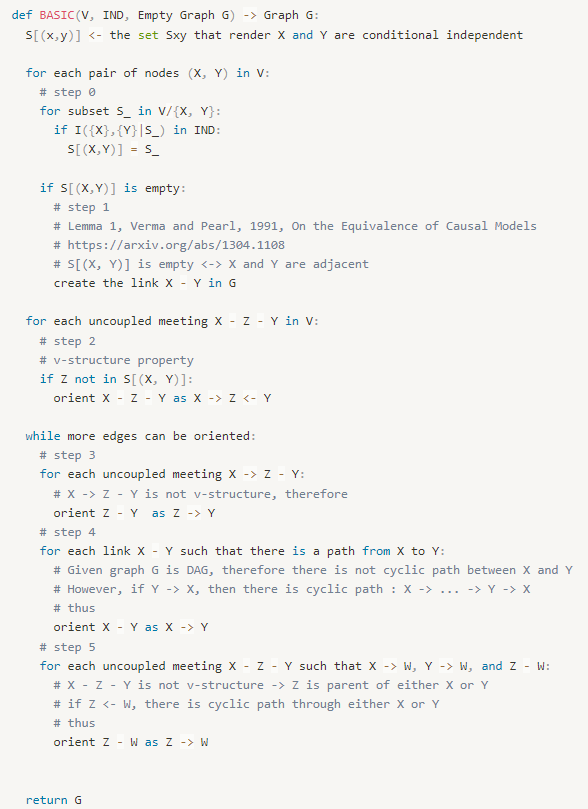 [3]

❗ The original code is C-style, so I modify the code to be similar to Python style

It effectively illustrates the primary framework of Constraint-based algorithms :
> Find Skeleton by relation of adjacency and d-separation (step 0 & 1)   
> → Find V-structure by lemma 1 (Verma and Pearl, 1991) [4] (step 2)   
> → Apply Meek rules [5] (step 3~5)   
> → Proof Soundness and Completeness with DAG pattern by the theorem of Meek [5]



#### Soundness & Completeness of basic algorithm

**If the set of d-separations, which are the input to the basic algorithm, admit a faithful DAG representation, the algorithm creates this DAG pattern containing the d-separations in this set.** In the other word, every link and directed edge in the DAG pattern created by the basic algorithm is **sound** and **complete** with link and directed edge in DAG pattern containing the d-separations in this set. 

**This fact is important. Because we can indirectly prove the soundness and completeness of our new constraint-based algorithm through this basic algorithm**. For example, PC algorithm modifies step 0 & 1 in the basic algorithm to improve efficiency. Also, conservative PC algorithm additionally modifies step 3 in PC algorithm. This is the reason why the name of this algorithm is 'basic'.

### Implementation

#### STEP 0 & 1 : Find Skeleton by relation of adjacency and d-separation ( = p-independence in practice)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from itertools import combinations, chain
from collections import defaultdict

In [2]:
# STEP 0
def identify_skeleton_from_empty_graph(self, data, test_kwarg):
    self.ptn = pattern()
    self.ptn.add_vertex(list(data.columns))

    self.p_independence_set = defaultdict(lambda: defaultdict(set))
    
    pairs = combinations(self.ptn.vertex, 2)
    for x, y in pairs:
        v_not_x_y = list(self.ptn.vertex - {x, y})
        power_set_of_v_not_x_y = chain(*[combinations(v_not_x_y, n) for n in range(len(v_not_x_y) + 1)])
        for subset in power_set_of_v_not_x_y:
            if self.test(data, {x}, {y}, set(subset), **test_kwarg):
                self.p_independence_set[x][y]
                self.p_independence_set[y][x] = self.p_independence_set[x][y]
                self.p_independence_set[x][y].add(subset)
                break

    self.identify_skeleton_by_ind(self.p_independence_set)

# STEP 1
def identify_skeleton_by_ind(self, ind, vertex:set = None):
    self.ptn.add_vertex(list(ind.keys()))
    if vertex is not None: self.ptn.add_vertex(vertex)

    self.p_independence_set = ind

    pairs = combinations(self.ptn.vertex, 2)

    for x, y in pairs:
        if len(self.p_independence_set[x][y]) == 0:
            self.ptn.add_link(x, y)

#### STEP 2 : Find V-structure with adjacency orient faithfulness

In [3]:
def identify_v_structure_with_adjacency_orient_faithfulness(self):
    uncoupled_triple = deque()
    for x in self.ptn.link.keys():
        for z in self.ptn.link[x].keys():
            for y in self.ptn.link[z].keys():
                # Check whether x-z-y is uncoulped meeting
                if x != y and not self.ptn.is_adjacent(x, y): 
                    # Check whether Z not in every S in S[(X, Y)]:
                    if all(z not in subset for subset in self.p_independence_set[x][y]) : uncoupled_triple.append((x, y, z))
    
    while uncoupled_triple:
        x, y, z = uncoupled_triple.popleft()
        #if Z not in every S in S[(X, Y)]:
        # orient X - Z - Y as X -> Z <- Y
        self.ptn.remove_links([(x,z), (y,z)])
        self.ptn.add_edges([(x,z), (y,z)])

#### STEP 3

In [4]:
def identify_meeks_rule_2(self):
    uncoupled_triple = deque()
    for x in self.ptn.child.keys():
        for z in self.ptn.child[x].keys():
            for y in self.ptn.link[z].keys():
                # Check whether x-z-y is uncoulped meeting
                if x != y and not self.ptn.is_adjacent(x, y): uncoupled_triple.append((x, y, z))

    if len(uncoupled_triple) == 0: return False

    while uncoupled_triple:
        x, y, z = uncoupled_triple.popleft()
        # X -> Z - Y is not v-structure, therefore 
        # orient Z - Y  as Z -> Y
        self.ptn.remove_links([(y,z)])
        self.ptn.add_edges([(z,y)])

    return True

#### STEP 4 

In [5]:
def identify_meeks_rule_3(self):
    pairs = deque()
    for x in self.ptn.link.keys():
        for y in self.ptn.link[x].keys(): 
            # Check there is a path X->Y
            if len(self.ptn.get_path(x, y, directed=True)) > 0: pairs.append((x, y))
    
    if len(pairs) == 0: return False

    while pairs:
        x, y = pairs.popleft()
        #Given graph G is DAG, therefore there is not cyclic path between X and Y
        #However, if Y -> X, then there is cyclic path : X -> ... -> Y -> X
        # thus orient X - Y as X -> Y
        self.ptn.remove_links([(x,y)])
        self.ptn.add_edges([(x,y)])
    
    return True

#### STEP 5

In [6]:
def identify_meeks_rule_4(self):
    pairs = deque()
    for w in self.ptn.parent.keys():
        # Find W which has more than two parents and at least one vertex linked with
        if len(self.ptn.parent[w].keys()) >= 2 and w in self.ptn.link.keys():
            linked_with_w = set(self.ptn.link[w].keys())

            # Find pair of parents of W (x, y) such that x is not adjacent with y
            # X   Y
            #  \ /
            #   ><
            #   W
            parent_of_w = list(self.ptn.parent[w].keys())
            xy = combinations(parent_of_w, 2)

            for x, y in xy:
                if not self.ptn.is_adjacent(x, y):
                    # Find Z such that X - Z, Y - Z, and W - Z
                    linked_with_x = set(self.ptn.link[x].keys())
                    linked_with_y = set(self.ptn.link[y].keys())
                    linked_with_x_y_w = linked_with_w & linked_with_x & linked_with_y

                    for z in linked_with_x_y_w: pairs.append((z, w))
    
    if len(pairs) == 0: return False
    while pairs:
        z, w = pairs.popleft()
        # Now, we know that 
        # X - Z - Y
        #  \  |  /
        #   > W <
        # X - Z - Y is not v-structure -> Z is parent of X or Y
        # if Z <- W, there is a cyclic path through X or Y 
        # thus orient Z - W as Z -> W

        self.ptn.remove_links([(z,w)])
        self.ptn.add_edges([(z,w)])

    return True

#### class basic

In [7]:
pip install cdpi --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from cdpi import pattern
from cdpi.causal_discovery.test import get_test

In [9]:
class basic:
    def __init__(self):
        self.ptn = pattern()
    
    def identify(self, data:pd.DataFrame = None, test:str = None, ind:dict = None, vertex = None, **test_kwarg) -> pattern: 
        # STEP 0 ~ 1 : Find skeleton
        if ind is not None:
            self.identify_skeleton_by_ind(ind, vertex)
        elif data is not None and test is not None:
            self.test = get_test(test)
            self.identify_skeleton_from_empty_graph(data, test_kwarg = test_kwarg)
        else:
            print("basic.identify : both ind and (data, test) are None!")

        # # STEP 2 : Find v-structure
        self.identify_v_structure_with_adjacency_orient_faithfulness()

        # STEP 3~5 : use Meek rules
        cnt = True
        while cnt:
          cnt2 = self.identify_meeks_rule_2()
          cnt3 = self.identify_meeks_rule_3()
          cnt4 = self.identify_meeks_rule_4()

          cnt = cnt2 or cnt3 or cnt4 # Check there are vertexs which could be changed

        return self.ptn

    def draw(self):
        self.ptn.draw()

    def draw_by_pos(self, pos):
        self.ptn.draw_by_pos(pos)
        
basic.identify_skeleton_from_empty_graph = identify_skeleton_from_empty_graph
basic.identify_v_structure_with_adjacency_orient_faithfulness = identify_v_structure_with_adjacency_orient_faithfulness
basic.identify_meeks_rule_2 = identify_meeks_rule_2
basic.identify_meeks_rule_3 = identify_meeks_rule_3
basic.identify_meeks_rule_4 = identify_meeks_rule_4
basic.identify_skeleton_by_ind = identify_skeleton_by_ind

### Example

In [10]:
np.random.seed(seed=2022)

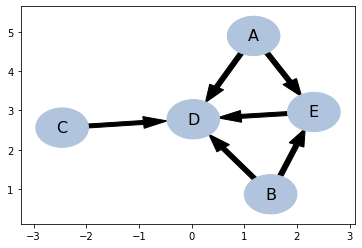

In [22]:
import scipy.stats as stats

size = 100

data = pd.DataFrame()
data['A'] =  stats.bernoulli(p = 0.5).rvs(size = size)
data['B'] =  stats.bernoulli(p = 0.5).rvs(size = size)
data['C'] =  stats.bernoulli(p = 0.5).rvs(size = size)
data['D'] =  data['A'] + data['B'] + data['C'] + stats.bernoulli(p = 0.5).rvs(size = size)
data['E'] =  data['A'] + data['B'] + stats.bernoulli(p = 0.5).rvs(size = size)

bsc = basic()
bsc.identify(data = data, test = 'conditional_mutual_information_test')
bsc.draw()

#### For given IND

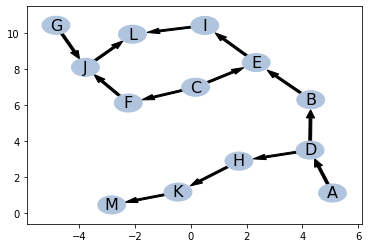

In [ ]:
ptn = pattern()
ptn.add_edges([
    ('A', 'D'),
    ('D', 'B'),
    ('B', 'E'),
    ('C', 'E'),
    ('C', 'F'),
    ('D', 'H'),
    ('E', 'I'),
    ('F', 'J'),
    ('H', 'K'),
    ('I', 'L'),
    ('J', 'L'),
    ('G', 'J'),
    ('K', 'M')
])
ptn.draw()
pos = ptn.pos

In [ ]:
ind = ptn.get_all_d_separation()

In [ ]:
bsc = basic()
bsc.identify(ind = ind)

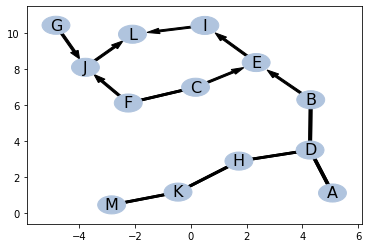

In [ ]:
bsc.ptn.draw_by_pos(pos)

### Reference

[3] Metropolitan. (2004). Learning Bayesian Networks. chapter 10.


[4] Verma, T., Pearl, J. (1990). On the Equivalence of Causal Models. Appears in Proceedings of the Sixth Conference on Uncertainty in Artificial Intelligence (UAI1990).


[5] Meek, C. (1995). Causal inference and causal explanation with background
knowledge. Conference on Uncertainty in Artificial Intelligence.
